In [1072]:
#Importing Required Modules:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [1073]:
#Loading Dataset:
df = pd.read_csv('data/tsla.csv')
df = df.sort_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-06,333.750000,336.369995,327.029999,328.200012,328.200012,4285700
1,2018-03-07,325.440002,332.500000,321.739990,332.299988,332.299988,5007300
2,2018-03-08,332.859985,333.299988,326.269989,329.100006,329.100006,3566200
3,2018-03-09,324.100006,328.489990,322.369995,327.170013,327.170013,5506800
4,2018-03-12,328.609985,347.209991,326.500000,345.510010,345.510010,8264000


In [1074]:
#Creating Timestamps:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
date_ori[:5]

[Timestamp('2018-03-06 00:00:00'),
 Timestamp('2018-03-07 00:00:00'),
 Timestamp('2018-03-08 00:00:00'),
 Timestamp('2018-03-09 00:00:00'),
 Timestamp('2018-03-12 00:00:00')]

In [1075]:
#Performing Data Pre-Processing:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.662494,0.598128,0.672815,0.601814,0.601814,0.039419
1,0.594502,0.567687,0.629642,0.633594,0.633594,0.063025
2,0.655212,0.573979,0.666612,0.608790,0.608790,0.015882
3,0.583538,0.536144,0.634783,0.593830,0.593830,0.079365
4,0.620438,0.683395,0.668489,0.735989,0.735989,0.169561


In [1076]:
#Defining Network Architecture:
class Model:
    def __init__(self,learning_rate,num_layers,size,size_layer,output_size,forget_bias = 0.1):
        def lstm_cell(size_layer):
            """
            Function to construct LSTM Layer
            """
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        # Creating LSTM's Unit:
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)],state_is_tuple = False,)
        
        # Create Placeholders for input and output:
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        # Adding Dropout Layer:
        drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)
        
        # Creating Hidden Layer:
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32)
        
        # Defining Output:
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        
        # Defining Loss Function:
        # Here Loss function is mean squared error:
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        
        # Here we use Adam optimizer:
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [1077]:
# Network Parameters:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 50

In [1078]:
# Creating Tensorflow Session:
tf.reset_default_graph()

# Passing Arguments to the Class:
model = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [1079]:
# Training of LSTM's:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    
    # Run a loop through the dataset:
    # We take every timestamp row are an input:
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] -1)
        
        # We take a datapoints from K to index:
        batch_x = np.expand_dims(df_log.iloc[k : index, :].values, axis = 0)
        
        # We take a datapoints from K+1 to index+1 as corresponding Y for X: 
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        
        # We train a LSTM Units using given data:
        last_state, _, loss = sess.run(
            [model.last_state, model.optimizer, model.cost],
            feed_dict = {model.X: batch_x,
                         model.Y: batch_y,
                         model.hidden_layer: init_value,},)
        init_value = last_state
        total_loss += loss
    
    # Show Mean Squared Loss for every 100 epochs: 
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('Epoch:', i + 1, 'Mean_Squared_Error:', total_loss)

Epoch: 100 Mean_Squared_Error: 0.009587188482983037
Epoch: 200 Mean_Squared_Error: 0.00930854101665318
Epoch: 300 Mean_Squared_Error: 0.007269195058615879
Epoch: 400 Mean_Squared_Error: 0.006546839054208249
Epoch: 500 Mean_Squared_Error: 0.0040870675351470705


In [1080]:
# Initializing Output Variable:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]

# Calculating UpperBound of Loop:
# We take Timestamp datapoints as input and results corresponding output:
# Here we take Timestamp = 5
# Total Number of datapoints in dataset=252:
# Upper_Bound = (252 // 5)*5 = 250
# Here Upper Bound is 250:
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))

# Predicting Datapoints Upto Upperbound: 
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [model.logits, model.last_state],
        feed_dict = {model.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 0),model.hidden_layer: init_value,},)
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits
    
# Predicting Datapoints Above the UpperBound:
out_logits, last_state = sess.run(
    [model.logits, model.last_state],
    feed_dict = {
        model.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        model.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [1081]:
# We take last Timestamp datapoints and predict future values:
# Values predicted upto given number of future days:
# Iterates through the Loop:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [model.logits, model.last_state],
        feed_dict = {
            model.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            model.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [1082]:
# Perform inverse min-max scaling to convert into original form: 
df_log = minmax.inverse_transform(output_predict)

# Appending Predicted Output dates:
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [1083]:
# Smoothing Function to visualize the results:
def anchor(signal, weight):
    """
    Output Smoothing Function
    """
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

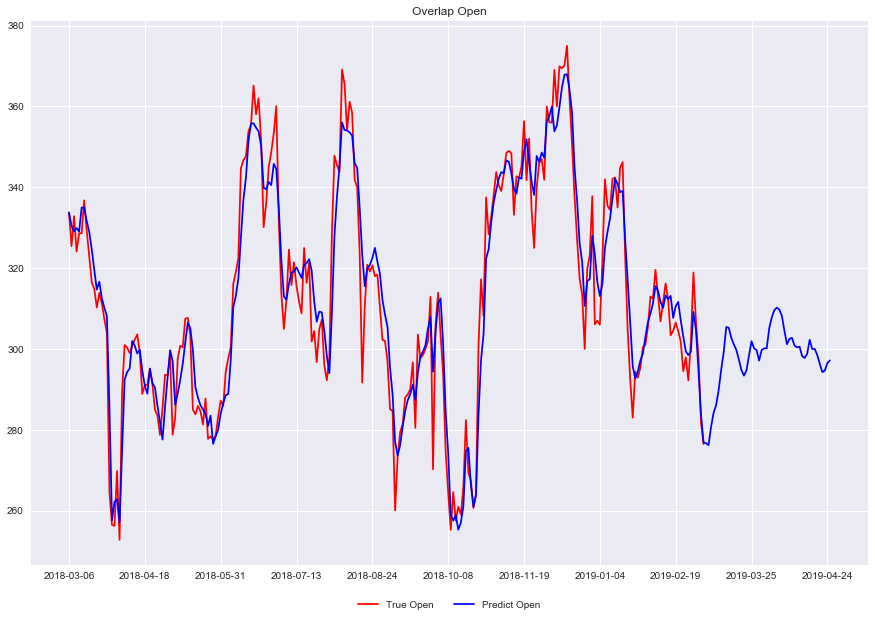

In [1084]:
plt.figure(figsize = (15, 10))
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])

# Visuaizing True and Predicted Open:
plt.plot(x_range_original,df.iloc[:, 1],'red',label = 'True Open')
plt.plot(x_range_future,anchor(df_log[:, 0], 0.5),'blue',label = 'Predict Open')
plt.title('Overlap Open')

plt.xticks(x_range_future[::30], date_ori[::30])
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5, -0.05),ncol = 5)
plt.savefig("output/open.jpg")
plt.show()

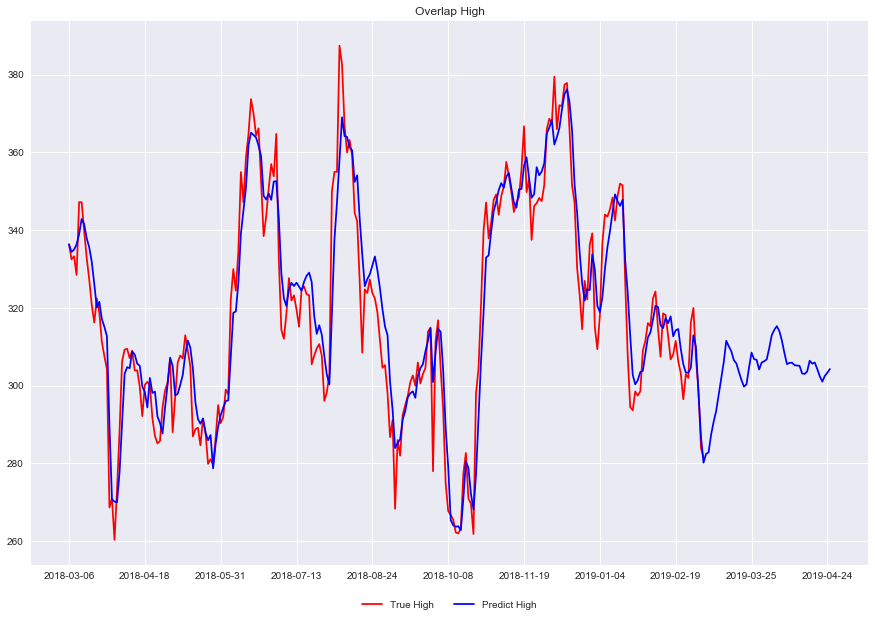

In [1085]:
# Visuaizing True and Predicted High:
plt.figure(figsize = (15, 10))
plt.plot(x_range_original,df.iloc[:, 2],'red',label = 'True High')
plt.plot(x_range_future,anchor(df_log[:, 1], 0.5),'blue',label = 'Predict High')
plt.title('Overlap High')

plt.xticks(x_range_future[::30], date_ori[::30])
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5, -0.05),ncol = 5)
plt.savefig("output/high.jpg")
plt.show()

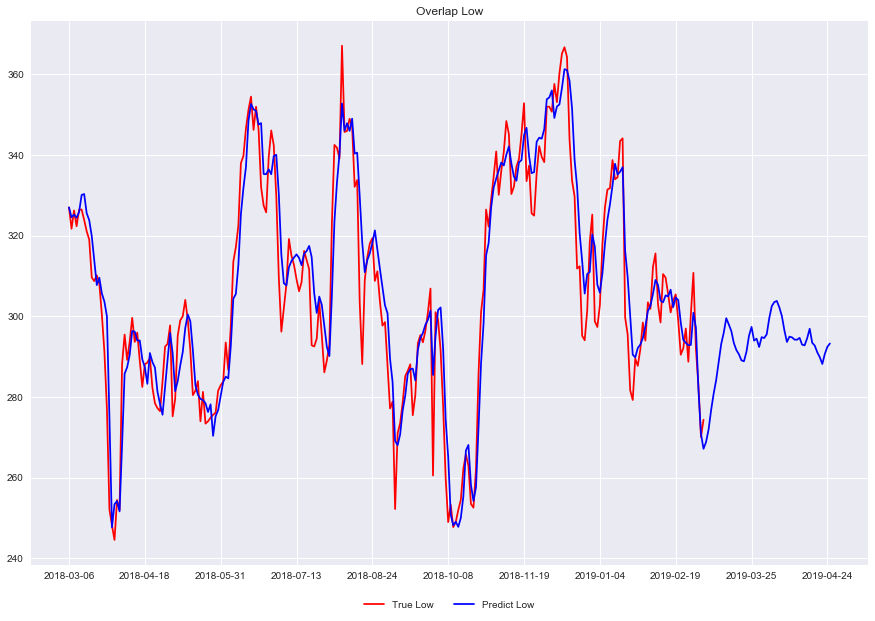

In [1086]:
# Visuaizing True and Predicted Low:
plt.figure(figsize = (15, 10))
plt.plot(x_range_original,df.iloc[:, 3],'red',label = 'True Low')
plt.plot(x_range_future,anchor(df_log[:, 2], 0.5),'blue',label = 'Predict Low')
plt.title('Overlap Low')

plt.xticks(x_range_future[::30], date_ori[::30])
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5, -0.05),ncol = 5)
plt.savefig("output/low.jpg")
plt.show()

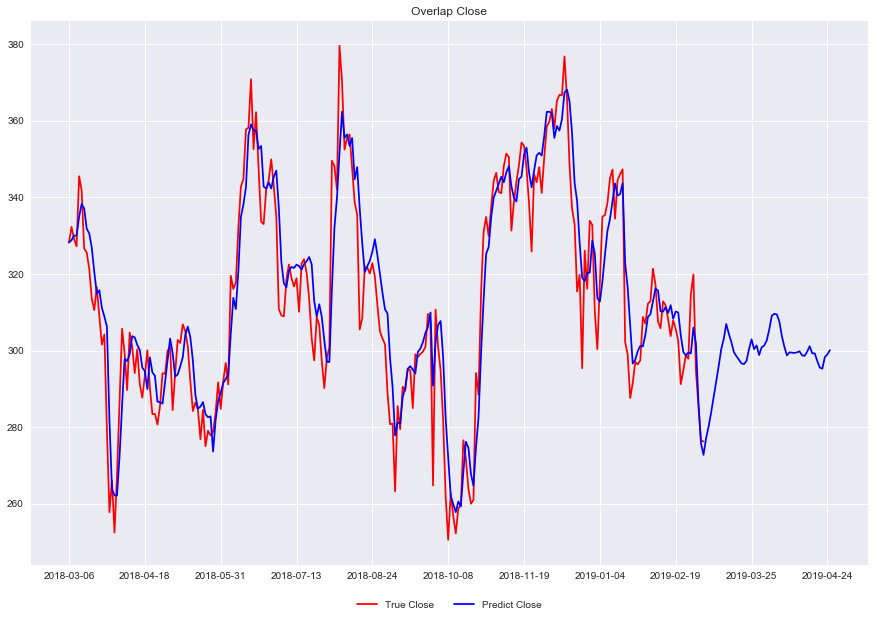

In [1087]:
# Visuaizing True and Predicted Close:
plt.figure(figsize = (15, 10))
plt.plot(x_range_original,df.iloc[:, 4],'red',label = 'True Close')
plt.plot(x_range_future,anchor(df_log[:, 3], 0.5),'blue',label = 'Predict Close')
plt.title('Overlap Close')

plt.xticks(x_range_future[::30], date_ori[::30])
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5, -0.05),ncol = 5)
plt.savefig("output/close.jpg")
plt.show()

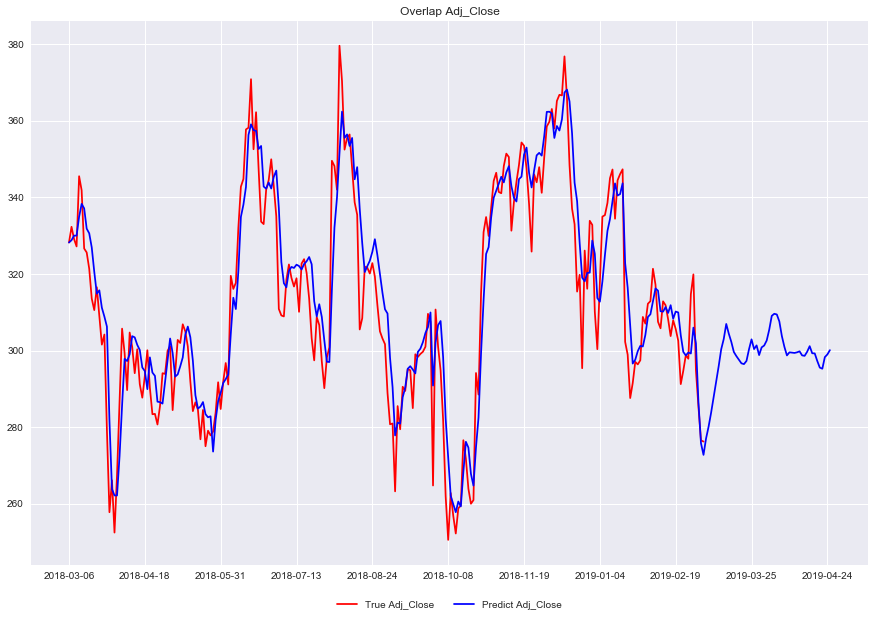

In [1088]:
# Visuaizing True and Predicted Adj_Close:
plt.figure(figsize = (15, 10))
plt.plot(x_range_original,df.iloc[:, 5],'red',label = 'True Adj_Close')
plt.plot(x_range_future,anchor(df_log[:, 4], 0.5),'blue',label = 'Predict Adj_Close')
plt.title('Overlap Adj_Close')

plt.xticks(x_range_future[::30], date_ori[::30])
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5, -0.05),ncol = 5)
plt.savefig("output/adj.jpg")
plt.show()

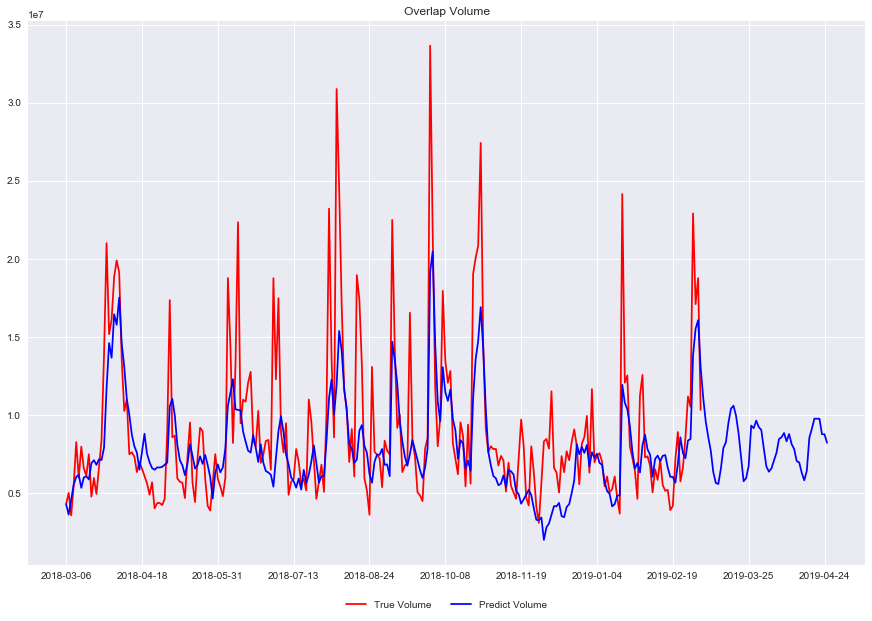

In [1089]:
# Visuaizing True and Predicted Volume:
plt.figure(figsize = (15, 10))
plt.plot(x_range_original,df.iloc[:, 6],'red',label = 'True Volume')
plt.plot(x_range_future,anchor(df_log[:, 5], 0.5),'blue',label = 'Predict Volume')
plt.title('Overlap Volume')

plt.xticks(x_range_future[::30], date_ori[::30])
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5, -0.05),ncol = 5)
plt.savefig("output/volume.jpg")
plt.show()